In [1]:
import sys
# from IPython.display import FileLink
# !pip download timm==0.4.12
#FileLink("timm-0.5.4-py3-none-any.whl")
#FileLink("timm-0.4.12-py3-none-any.whl")
#!pip download segmentation-models-pytorch
#FileLink("segmentation_models_pytorch-0.2.1-py3-none-any.whl")
#FileLink("pretrainedmodels-0.7.4.tar.gz")
#FileLink("efficientnet_pytorch-0.6.3.tar.gz")
#!pip download staintools
#FileLink("staintools-2.1.2.tar.gz")
#!pip download spams
#FileLink("spams-2.6.5.4.tar.gz")
!cp -R /kaggle/input/jph-hubmap2022-wheels/* ./
!cp -R /kaggle/input/einops-030/* ./
# !ls
#!pip install 'timm-0.5.4-py3-none-any.whl'
!pip install 'timm-0.4.12-py3-none-any.whl'
# !pip install 'pretrainedmodels-0.7.4/pretrainedmodels-0.7.4'
!pip install 'efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3'
!pip install 'einops-0.3.0-py2.py3-none-any.whl'
sys.path.append("../input/pretrained-models-pytorch")
# sys.path.append("../input/efficientnet-pytorch")
sys.path.append("../input/segmentation-models-pytorch")
# !pip install 'segmentation_models_pytorch-0.2.1-py3-none-any.whl'
!pip install 'spams-2.6.1/spams-2.6.1'
!pip install 'staintools-2.1.2/staintools-2.1.2'
sys.path.append("../input/timm-pytorch-image-models/pytorch-image-models-master")


Processing ./timm-0.4.12-py3-none-any.whl
Processing ./efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
  Preparing metadata (setup.py) ... - done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=360f6965f4cbe5d080ed49f2b3f671ac31b65fe8b78365d1c5b0f8e57843c6d4
  Stored in directory: /root/.cache/pip/wheels/62/3e/05/28ddbc1dffafc06e5824445dc1a187b90af6478b2d146ea960
Successfully built efficientnet-pytorch
Processing ./einops-0.3.0-py2.py3-none-any.whl
Processing ./spams-2.6.1/spams-2.6.1
  Preparing metadata (setup.py) ... - done
  Created wheel for spams: filename=spams-2.6.1-cp37-cp37m-linux_x86_64.whl size=5971890 sha256=f6d600ceeb786ffb5b1cb547c313e396543a04aeac1ec96540f2e4edd87a6b1d
  Stored in directory: /root/.cache/pip/wheels/2c/0d/87/b1dce9951f8dec8914a5c573cad79bc532952753491120666b
Successfully built spams
Processing ./staintools-2.1.2/staintools-2.1.2
  Preparing metadata (setup.py) ... - done
  Creat

In [2]:
import os
import cv2
import shutil
import random
import tifffile
import staintools
import numpy as np
import pandas as pd
import albumentations as A

from glob import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
import segmentation_models_pytorch as smp
from tqdm import tqdm
from transformers import SegformerForSemanticSegmentation, SegformerConfig
from transformers.modeling_outputs import SemanticSegmenterOutput

In [3]:
# https://github.com/mlpc-ucsd/CoaT/blob/main/src/models/coat.py
from functools import partial
from einops import rearrange
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from torch import nn, einsum

# ---------------------------------------------
# https://github.com/facebookresearch/ConvNeXt/blob/main/models/convnext.py#L15
class LayerNorm2d(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.dim = dim
        self.weight = nn.Parameter(torch.ones(dim))
        self.bias = nn.Parameter(torch.zeros(dim))
        self.eps = eps

    def forward(self, x):
        batch_size, C, H, W = x.shape
        # assert C==self.dim, 'C=%d, self.dim=%d'%(C,self.dim)
        # print('C=%d, self.dim=%d'%(C,self.dim))

        u = x.mean(1, keepdim=True)
        s = (x - u).pow(2).mean(1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.eps)
        x = self.weight[:, None, None] * x + self.bias[:, None, None]
        return x


# ---------------------------------------------

def _cfg_coat(url='', **kwargs):
    return {
        'url': url,
        'num_classes': 1000, 'input_size': (3, 224, 224), 'pool_size': None,
        'crop_pct': .9, 'interpolation': 'bicubic',
        'mean': IMAGENET_DEFAULT_MEAN, 'std': IMAGENET_DEFAULT_STD,
        'first_conv': 'patch_embed.proj', 'classifier': 'head',
        **kwargs
    }


class Mlp(nn.Module):
    """ Feed-forward network (FFN, a.k.a. MLP) class. """

    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class ConvRelPosEnc(nn.Module):
    """ Convolutional relative position encoding. """

    def __init__(self, Ch, h, window):
        """
        Initialization.
            Ch: Channels per head.
            h: Number of heads.
            window: Window size(s) in convolutional relative positional encoding. It can have two forms:
                    1. An integer of window size, which assigns all attention heads with the same window size in ConvRelPosEnc.
                    2. A dict mapping window size to #attention head splits (e.g. {window size 1: #attention head split 1, window size 2: #attention head split 2})
                       It will apply different window size to the attention head splits.
        """
        super().__init__()

        if isinstance(window, int):
            window = {window: h}  # Set the same window size for all attention heads.
            self.window = window
        elif isinstance(window, dict):
            self.window = window
        else:
            raise ValueError()

        self.conv_list = nn.ModuleList()
        self.head_splits = []
        for cur_window, cur_head_split in window.items():
            dilation = 1  # Use dilation=1 at default.
            padding_size = (cur_window + (cur_window - 1) * (
                    dilation - 1)) // 2  # Determine padding size. Ref: https://discuss.pytorch.org/t/how-to-keep-the-shape-of-input-and-output-same-when-dilation-conv/14338
            cur_conv = nn.Conv2d(cur_head_split * Ch, cur_head_split * Ch,
                                 kernel_size=(cur_window, cur_window),
                                 padding=(padding_size, padding_size),
                                 dilation=(dilation, dilation),
                                 groups=cur_head_split * Ch,
                                 )
            self.conv_list.append(cur_conv)
            self.head_splits.append(cur_head_split)
        self.channel_splits = [x * Ch for x in self.head_splits]

    def forward(self, q, v, size):
        B, h, N, Ch = q.shape
        H, W = size
        assert N == 1 + H * W

        # Convolutional relative position encoding.
        q_img = q[:, :, 1:, :]  # Shape: [B, h, H*W, Ch].
        v_img = v[:, :, 1:, :]  # Shape: [B, h, H*W, Ch].

        v_img = rearrange(v_img, 'B h (H W) Ch -> B (h Ch) H W', H=H, W=W)  # Shape: [B, h, H*W, Ch] -> [B, h*Ch, H, W].
        v_img_list = torch.split(v_img, self.channel_splits, dim=1)  # Split according to channels.
        conv_v_img_list = [conv(x) for conv, x in zip(self.conv_list, v_img_list)]
        conv_v_img = torch.cat(conv_v_img_list, dim=1)
        conv_v_img = rearrange(conv_v_img, 'B (h Ch) H W -> B h (H W) Ch',
                               h=h)  # Shape: [B, h*Ch, H, W] -> [B, h, H*W, Ch].

        EV_hat_img = q_img * conv_v_img
        zero = torch.zeros((B, h, 1, Ch), dtype=q.dtype, layout=q.layout, device=q.device)
        EV_hat = torch.cat((zero, EV_hat_img), dim=2)  # Shape: [B, h, N, Ch].

        return EV_hat


class FactorAtt_ConvRelPosEnc(nn.Module):
    """ Factorized attention with convolutional relative position encoding class. """

    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0., shared_crpe=None):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)  # Note: attn_drop is actually not used.
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        # Shared convolutional relative position encoding.
        self.crpe = shared_crpe

    def forward(self, x, size):
        B, N, C = x.shape

        # Generate Q, K, V.
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1,
                                                                                        4)  # Shape: [3, B, h, N, Ch].
        q, k, v = qkv[0], qkv[1], qkv[2]  # Shape: [B, h, N, Ch].

        # Factorized attention.
        k_softmax = k.softmax(dim=2)  # Softmax on dim N.
        k_softmax_T_dot_v = einsum('b h n k, b h n v -> b h k v', k_softmax, v)  # Shape: [B, h, Ch, Ch].
        factor_att = einsum('b h n k, b h k v -> b h n v', q, k_softmax_T_dot_v)  # Shape: [B, h, N, Ch].

        # Convolutional relative position encoding.
        crpe = self.crpe(q, v, size=size)  # Shape: [B, h, N, Ch].

        # Merge and reshape.
        x = self.scale * factor_att + crpe
        x = x.transpose(1, 2).reshape(B, N, C)  # Shape: [B, h, N, Ch] -> [B, N, h, Ch] -> [B, N, C].

        # Output projection.
        x = self.proj(x)
        x = self.proj_drop(x)

        return x  # Shape: [B, N, C].


class ConvPosEnc(nn.Module):
    """ Convolutional Position Encoding.
        Note: This module is similar to the conditional position encoding in CPVT.
    """

    def __init__(self, dim, k=3):
        super(ConvPosEnc, self).__init__()
        self.proj = nn.Conv2d(dim, dim, k, 1, k // 2, groups=dim)

    def forward(self, x, size):
        B, N, C = x.shape
        H, W = size
        assert N == 1 + H * W

        # Extract CLS token and image tokens.
        cls_token, img_tokens = x[:, :1], x[:, 1:]  # Shape: [B, 1, C], [B, H*W, C].

        # Depthwise convolution.
        feat = img_tokens.transpose(1, 2).view(B, C, H, W)
        x = self.proj(feat) + feat
        x = x.flatten(2).transpose(1, 2)

        # Combine with CLS token.
        x = torch.cat((cls_token, x), dim=1)

        return x


class SerialBlock(nn.Module):
    """ Serial block class.
        Note: In this implementation, each serial block only contains a conv-attention and a FFN (MLP) module. """

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm,
                 shared_cpe=None, shared_crpe=None):
        super().__init__()

        # Conv-Attention.
        self.cpe = shared_cpe

        self.norm1 = norm_layer(dim)
        self.factoratt_crpe = FactorAtt_ConvRelPosEnc(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop,
            shared_crpe=shared_crpe)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

        # MLP.
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x, size):
        # Conv-Attention.
        x = self.cpe(x, size)  # Apply convolutional position encoding.
        cur = self.norm1(x)
        cur = self.factoratt_crpe(cur, size)  # Apply factorized attention and convolutional relative position encoding.
        x = x + self.drop_path(cur)

        # MLP.
        cur = self.norm2(x)
        cur = self.mlp(cur)
        x = x + self.drop_path(cur)

        return x


class ParallelBlock(nn.Module):
    """ Parallel block class. """

    def __init__(self, dims, num_heads, mlp_ratios=[], qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm,
                 shared_cpes=None, shared_crpes=None):
        super().__init__()

        # Conv-Attention.
        self.cpes = shared_cpes

        self.norm12 = norm_layer(dims[1])
        self.norm13 = norm_layer(dims[2])
        self.norm14 = norm_layer(dims[3])
        self.norm15 = norm_layer(dims[4])

        self.factoratt_crpe2 = FactorAtt_ConvRelPosEnc(
            dims[1], num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop,
            shared_crpe=shared_crpes[1]
        )
        self.factoratt_crpe3 = FactorAtt_ConvRelPosEnc(
            dims[2], num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop,
            shared_crpe=shared_crpes[2]
        )
        self.factoratt_crpe4 = FactorAtt_ConvRelPosEnc(
            dims[3], num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop,
            shared_crpe=shared_crpes[3]
        )
        self.factoratt_crpe5 = FactorAtt_ConvRelPosEnc(
            dims[4], num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop,
            shared_crpe=shared_crpes[4]
        )

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

        # MLP.
        self.norm22 = norm_layer(dims[1])
        self.norm23 = norm_layer(dims[2])
        self.norm24 = norm_layer(dims[3])
        self.norm25 = norm_layer(dims[4])

        assert dims[1] == dims[2] == dims[3] == dims[
            4]  # In parallel block, we assume dimensions are the same and share the linear transformation.
        assert mlp_ratios[1] == mlp_ratios[2] == mlp_ratios[3]
        mlp_hidden_dim = int(dims[1] * mlp_ratios[1])
        self.mlp2 = self.mlp3 = self.mlp4 = self.mlp5 = Mlp(in_features=dims[1], hidden_features=mlp_hidden_dim,
                                                            act_layer=act_layer, drop=drop)

    def upsample(self, x, output_size, size):
        """ Feature map up-sampling. """
        return self.interpolate(x, output_size=output_size, size=size)

    def downsample(self, x, output_size, size):
        """ Feature map down-sampling. """
        return self.interpolate(x, output_size=output_size, size=size)

    def interpolate(self, x, output_size, size):
        """ Feature map interpolation. """
        B, N, C = x.shape
        H, W = size
        assert N == 1 + H * W

        cls_token = x[:, :1, :]
        img_tokens = x[:, 1:, :]

        img_tokens = img_tokens.transpose(1, 2).reshape(B, C, H, W)
        img_tokens = F.interpolate(img_tokens, size=output_size, mode='bilinear')  # FIXME: May have alignment issue.
        img_tokens = img_tokens.reshape(B, C, -1).transpose(1, 2)

        out = torch.cat((cls_token, img_tokens), dim=1)

        return out

    def forward(self, x1, x2, x3, x4, x5, sizes):
        _, (H2, W2), (H3, W3), (H4, W4), (H5, W5) = sizes

        # Conv-Attention.
        x2 = self.cpes[1](x2, size=(H2, W2))  # Note: x1 is ignored.
        x3 = self.cpes[2](x3, size=(H3, W3))
        x4 = self.cpes[3](x4, size=(H4, W4))
        x5 = self.cpes[4](x5, size=(H5, W5))

        cur2 = self.norm12(x2)
        cur3 = self.norm13(x3)
        cur4 = self.norm14(x4)
        cur5 = self.norm15(x5)

        cur2 = self.factoratt_crpe2(cur2, size=(H2, W2))
        cur3 = self.factoratt_crpe3(cur3, size=(H3, W3))
        cur4 = self.factoratt_crpe4(cur4, size=(H4, W4))
        cur5 = self.factoratt_crpe4(cur5, size=(H5, W5))

        upsample3_2 = self.upsample(cur3, output_size=(H2, W2), size=(H3, W3))
        upsample4_3 = self.upsample(cur4, output_size=(H3, W3), size=(H4, W4))
        upsample4_2 = self.upsample(cur4, output_size=(H2, W2), size=(H4, W4))
        downsample2_3 = self.downsample(cur2, output_size=(H3, W3), size=(H2, W2))
        downsample3_4 = self.downsample(cur3, output_size=(H4, W4), size=(H3, W3))
        downsample2_4 = self.downsample(cur2, output_size=(H4, W4), size=(H2, W2))
        upsample5_2 = self.upsample(cur5, output_size=(H2, W2), size=(H5, W5))
        upsample5_3 = self.upsample(cur5, output_size=(H3, W3), size=(H5, W5))
        downsample3_5 = self.downsample(cur3, output_size=(H5, W5), size=(H3, W3))
        upsample5_4 = self.upsample(cur5, output_size=(H4, W4), size=(H5, W5))
        downsample2_5 = self.downsample(cur2, output_size=(H5, W5), size=(H2, W2))
        downsample4_5 = self.downsample(cur4, output_size=(H5, W5), size=(H4, W4))

        # cur2 = cur2  + upsample3_2   + upsample4_2+  upsample5_2
        # cur3 = cur3  + upsample4_3   + downsample2_3 + upsample5_3
        # cur4 = cur4  + downsample3_4 + downsample2_4 + upsample5_4
        # cur5 = cur5  + downsample3_5 + downsample2_5 + downsample4_5 4
        # not use all connetction
        cur2 = cur2 + upsample3_2 + upsample4_2
        cur3 = cur3 + upsample4_3 + downsample2_3
        cur4 = cur4 + upsample5_4 + downsample2_4
        cur5 = cur5 + downsample4_5 + downsample2_5

        x2 = x2 + self.drop_path(cur2)
        x3 = x3 + self.drop_path(cur3)
        x4 = x4 + self.drop_path(cur4)
        x5 = x5 + self.drop_path(cur5)

        # MLP.
        cur2 = self.norm22(x2)
        cur3 = self.norm23(x3)
        cur4 = self.norm24(x4)
        cur5 = self.norm25(x5)

        cur2 = self.mlp2(cur2)
        cur3 = self.mlp3(cur3)
        cur4 = self.mlp4(cur4)
        cur5 = self.mlp5(cur5)

        x2 = x2 + self.drop_path(cur2)
        x3 = x3 + self.drop_path(cur3)
        x4 = x4 + self.drop_path(cur4)
        x5 = x5 + self.drop_path(cur5)

        return x1, x2, x3, x4, x5

class PatchEmbed(nn.Module):
    """ Image to Patch Embedding """

    def __init__(self, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        patch_size = to_2tuple(patch_size)

        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        _, _, H, W = x.shape
        out_H, out_W = H // self.patch_size[0], W // self.patch_size[1]

        x = self.proj(x).flatten(2).transpose(1, 2)
        out = self.norm(x)

        return out, (out_H, out_W)


class CoaT(nn.Module):
    """ CoaT class. """

    def __init__(self, patch_size=16, in_chans=3, embed_dims=[0, 0, 0, 0],
                 serial_depths=[0, 0, 0, 0], parallel_depth=0,
                 num_heads=0, mlp_ratios=[0, 0, 0, 0], qkv_bias=True, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0.,
                 norm_layer=partial(nn.LayerNorm, eps=1e-6),
                 return_interm_layers=True,
                 # out_features=['x1_nocls','x2_nocls','x3_nocls','x4_nocls',],
                 crpe_window={3: 2, 5: 3, 7: 3},
                 pretrain=None,
                 out_norm=nn.Identity,  # use nn.Identity, nn.BatchNorm2d, LayerNorm2d
                 **kwargs):
        super().__init__()
        self.return_interm_layers = return_interm_layers
        self.pretrain = pretrain
        self.embed_dims = embed_dims
        # self.out_features = out_features
        # self.num_classes  = num_classes

        # Patch embeddings.
        self.patch_embed1 = PatchEmbed(patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dims[0])
        self.patch_embed2 = PatchEmbed(patch_size=2, in_chans=embed_dims[0], embed_dim=embed_dims[1])
        self.patch_embed3 = PatchEmbed(patch_size=2, in_chans=embed_dims[1], embed_dim=embed_dims[2])
        self.patch_embed4 = PatchEmbed(patch_size=2, in_chans=embed_dims[2], embed_dim=embed_dims[3])

        # Class tokens.
        self.cls_token1 = nn.Parameter(torch.zeros(1, 1, embed_dims[0]))
        self.cls_token2 = nn.Parameter(torch.zeros(1, 1, embed_dims[1]))
        self.cls_token3 = nn.Parameter(torch.zeros(1, 1, embed_dims[2]))
        self.cls_token4 = nn.Parameter(torch.zeros(1, 1, embed_dims[3]))

        # Convolutional position encodings.
        self.cpe1 = ConvPosEnc(dim=embed_dims[0], k=3)
        self.cpe2 = ConvPosEnc(dim=embed_dims[1], k=3)
        self.cpe3 = ConvPosEnc(dim=embed_dims[2], k=3)
        self.cpe4 = ConvPosEnc(dim=embed_dims[3], k=3)

        # Convolutional relative position encodings.
        self.crpe1 = ConvRelPosEnc(Ch=embed_dims[0] // num_heads, h=num_heads, window=crpe_window)
        self.crpe2 = ConvRelPosEnc(Ch=embed_dims[1] // num_heads, h=num_heads, window=crpe_window)
        self.crpe3 = ConvRelPosEnc(Ch=embed_dims[2] // num_heads, h=num_heads, window=crpe_window)
        self.crpe4 = ConvRelPosEnc(Ch=embed_dims[3] // num_heads, h=num_heads, window=crpe_window)

        # Enable stochastic depth.
        dpr = drop_path_rate

        # Serial blocks 1.
        self.serial_blocks1 = nn.ModuleList([
            SerialBlock(
                dim=embed_dims[0], num_heads=num_heads, mlp_ratio=mlp_ratios[0], qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr, norm_layer=norm_layer,
                shared_cpe=self.cpe1, shared_crpe=self.crpe1
            )
            for _ in range(serial_depths[0])]
        )

        # Serial blocks 2.
        self.serial_blocks2 = nn.ModuleList([
            SerialBlock(
                dim=embed_dims[1], num_heads=num_heads, mlp_ratio=mlp_ratios[1], qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr, norm_layer=norm_layer,
                shared_cpe=self.cpe2, shared_crpe=self.crpe2
            )
            for _ in range(serial_depths[1])]
        )

        # Serial blocks 3.
        self.serial_blocks3 = nn.ModuleList([
            SerialBlock(
                dim=embed_dims[2], num_heads=num_heads, mlp_ratio=mlp_ratios[2], qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr, norm_layer=norm_layer,
                shared_cpe=self.cpe3, shared_crpe=self.crpe3
            )
            for _ in range(serial_depths[2])]
        )

        # Serial blocks 4.
        self.serial_blocks4 = nn.ModuleList([
            SerialBlock(
                dim=embed_dims[3], num_heads=num_heads, mlp_ratio=mlp_ratios[3], qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr, norm_layer=norm_layer,
                shared_cpe=self.cpe4, shared_crpe=self.crpe4
            )
            for _ in range(serial_depths[3])]
        )

        # Parallel blocks.
        self.parallel_depth = parallel_depth
        if self.parallel_depth > 0:
            self.parallel_blocks = nn.ModuleList([
                ParallelBlock(
                    dims=embed_dims, num_heads=num_heads, mlp_ratios=mlp_ratios, qkv_bias=qkv_bias, qk_scale=qk_scale,
                    drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr, norm_layer=norm_layer,
                    shared_cpes=[self.cpe1, self.cpe2, self.cpe3, self.cpe4],
                    shared_crpes=[self.crpe1, self.crpe2, self.crpe3, self.crpe4]
                )
                for _ in range(parallel_depth)]
            )

        # add a norm layer for each output
        self.out_norm = nn.ModuleList(
            [out_norm(embed_dims[i]) for i in range(4)]
        )

        # Initialize weights.
        trunc_normal_(self.cls_token1, std=.02)
        trunc_normal_(self.cls_token2, std=.02)
        trunc_normal_(self.cls_token3, std=.02)
        trunc_normal_(self.cls_token4, std=.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'cls_token1', 'cls_token2', 'cls_token3', 'cls_token4'}

    def insert_cls(self, x, cls_token):
        """ Insert CLS token. """
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        return x

    def remove_cls(self, x):
        """ Remove CLS token. """
        return x[:, 1:, :]

    def forward(self, x0):
        B = x0.shape[0]

        # Serial blocks 1.
        x1, (H1, W1) = self.patch_embed1(x0)
        cls = self.cls_token1  # torch.zeros_like(self.cls_token1)#self.cls_token1
        x1 = self.insert_cls(x1, cls)
        for blk in self.serial_blocks1:
            x1 = blk(x1, size=(H1, W1))
        x1_nocls = self.remove_cls(x1)
        x1_nocls = x1_nocls.reshape(B, H1, W1, -1).permute(0, 3, 1, 2).contiguous()

        # Serial blocks 2.
        x2, (H2, W2) = self.patch_embed2(x1_nocls)
        cls = self.cls_token2  # torch.zeros_like(self.cls_token2)#self.cls_token2#
        x2 = self.insert_cls(x2, cls)
        for blk in self.serial_blocks2:
            x2 = blk(x2, size=(H2, W2))
        x2_nocls = self.remove_cls(x2)
        x2_nocls = x2_nocls.reshape(B, H2, W2, -1).permute(0, 3, 1, 2).contiguous()

        # Serial blocks 3.
        x3, (H3, W3) = self.patch_embed3(x2_nocls)
        cls = self.cls_token3  # torch.zeros_like(self.cls_token3)# self.cls_token3
        x3 = self.insert_cls(x3, cls)
        for blk in self.serial_blocks3:
            x3 = blk(x3, size=(H3, W3))
        x3_nocls = self.remove_cls(x3)
        x3_nocls = x3_nocls.reshape(B, H3, W3, -1).permute(0, 3, 1, 2).contiguous()

        # Serial blocks 4.
        x4, (H4, W4) = self.patch_embed4(x3_nocls)
        cls = self.cls_token4  # torch.zeros_like(self.cls_token4)#self.cls_token4
        x4 = self.insert_cls(x4, cls)
        for blk in self.serial_blocks4:
            x4 = blk(x4, size=(H4, W4))
        x4_nocls = self.remove_cls(x4)
        x4_nocls = x4_nocls.reshape(B, H4, W4, -1).permute(0, 3, 1, 2).contiguous()

        # Only serial blocks: Early return. ------------------------
        if self.parallel_depth == 0:
            x1_nocls = self.out_norm[0](x1_nocls)
            x2_nocls = self.out_norm[1](x2_nocls)
            x3_nocls = self.out_norm[2](x3_nocls)
            x4_nocls = self.out_norm[3](x4_nocls)
            return [x1_nocls, x2_nocls, x3_nocls, x4_nocls]

        # Parallel blocks. ------------------------------------------
        if self.parallel_depth > 0:

            for blk in self.parallel_blocks:
                x1, x2, x3, x4 = blk(x1, x2, x3, x4, sizes=[(H1, W1), (H2, W2), (H3, W3), (H4, W4)])

            x1_nocls = self.remove_cls(x1)
            x1_nocls = x1_nocls.reshape(B, H1, W1, -1).permute(0, 3, 1, 2).contiguous()
            x1_nocls = self.out_norm[0](x1_nocls)

            x2_nocls = self.remove_cls(x2)
            x2_nocls = x2_nocls.reshape(B, H2, W2, -1).permute(0, 3, 1, 2).contiguous()
            x2_nocls = self.out_norm[1](x2_nocls)

            x3_nocls = self.remove_cls(x3)
            x3_nocls = x3_nocls.reshape(B, H3, W3, -1).permute(0, 3, 1, 2).contiguous()
            x3_nocls = self.out_norm[2](x3_nocls)

            x4_nocls = self.remove_cls(x4)
            x4_nocls = x4_nocls.reshape(B, H4, W4, -1).permute(0, 3, 1, 2).contiguous()
            x4_nocls = self.out_norm[3](x4_nocls)

            return [x1_nocls, x2_nocls, x3_nocls, x4_nocls]

class coat_lite_small(CoaT):
    def __init__(self, **kwargs):
        super(coat_lite_small, self).__init__(
            patch_size=4,
            embed_dims=[64, 128, 320, 512],
            serial_depths=[3, 4, 6, 3],
            parallel_depth=0,
            num_heads=8,
            mlp_ratios=[8, 8, 4, 4],
            **kwargs)


# @register_model
class coat_lite_medium(CoaT):
    def __init__(self, **kwargs):
        super(coat_lite_medium, self).__init__(
            patch_size=4,
            embed_dims=[128, 256, 320, 512],
            serial_depths=[3, 6, 10, 8],
            parallel_depth=0,
            num_heads=8,
            mlp_ratios=[4, 4, 4, 4],
            pretrain='coat_lite_medium_384x384_f9129688.pth',
            **kwargs)


class coat_parallel_small_plus1(CoaT):
    def __init__(self, **kwargs):
        super(coat_parallel_small_plus1, self).__init__(
            patch_size=4,
            embed_dims=[152, 320, 320, 320, 320],
            serial_depths=[2, 2, 2, 2, 2],
            parallel_depth=6,
            num_heads=8,
            mlp_ratios=[4, 4, 4, 4, 4],
            pretrain='coat_small_7479cf9b.pth',
            **kwargs)


class MixUpSample(nn.Module):
    def __init__(self, scale_factor=2):
        super().__init__()
        assert (scale_factor != 1)

        self.mixing = nn.Parameter(torch.tensor(0.5))
        self.scale_factor = scale_factor

    def forward(self, x):
        x = self.mixing * F.interpolate(x, scale_factor=self.scale_factor, mode='bilinear', align_corners=False) \
            + (1 - self.mixing) * F.interpolate(x, scale_factor=self.scale_factor, mode='nearest')
        return x


# https://github.com/lhoyer/DAFormer/blob/master/mmseg/models/decode_heads/daformer_head.py
def Conv2dBnReLU(in_channel, out_channel, kernel_size=3, padding=1, stride=1, dilation=1):
    return nn.Sequential(
        nn.Conv2d(in_channel, out_channel, kernel_size=kernel_size, padding=padding, stride=stride, dilation=dilation,
                  bias=False),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(inplace=True),
    )


class ASPP(nn.Module):

    def __init__(self,
                 in_channel,
                 channel,
                 dilation,
                 ):
        super(ASPP, self).__init__()

        self.conv = nn.ModuleList()
        for d in dilation:
            self.conv.append(
                Conv2dBnReLU(
                    in_channel,
                    channel,
                    kernel_size=1 if d == 1 else 3,
                    dilation=d,
                    padding=0 if d == 1 else d,
                )
            )

        self.out = Conv2dBnReLU(
            len(dilation) * channel,
            channel,
            kernel_size=3,
            padding=1,
        )

    def forward(self, x):
        aspp = []
        for conv in self.conv:
            aspp.append(conv(x))
        aspp = torch.cat(aspp, dim=1)
        out = self.out(aspp)
        return out


# DepthwiseSeparable
class DSConv2d(nn.Module):
    def __init__(self,
                 in_channel,
                 out_channel,
                 kernel_size,
                 stride=1,
                 padding=0,
                 dilation=1
                 ):
        super().__init__()

        self.depthwise = nn.Sequential(
            nn.Conv2d(in_channel, in_channel, kernel_size, stride=stride, padding=padding, dilation=dilation),
            nn.BatchNorm2d(in_channel),
            nn.ReLU(inplace=True)
        )

        self.pointwise = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x


class DSASPP(nn.Module):

    def __init__(self,
                 in_channel,
                 channel,
                 dilation,
                 ):
        super(DSASPP, self).__init__()

        self.conv = nn.ModuleList()
        for d in dilation:
            if d == 1:
                self.conv.append(
                    Conv2dBnReLU(
                        in_channel,
                        channel,
                        kernel_size=1 if d == 1 else 3,
                        dilation=d,
                        padding=0 if d == 1 else d,
                    )
                )
            else:
                self.conv.append(
                    DSConv2d(
                        in_channel,
                        channel,
                        kernel_size=3,
                        dilation=d,
                        padding=d,
                    )
                )

        self.out = Conv2dBnReLU(
            len(dilation) * channel,
            channel,
            kernel_size=3,
            padding=1,
        )

    def forward(self, x):
        aspp = []
        for conv in self.conv:
            aspp.append(conv(x))
        aspp = torch.cat(aspp, dim=1)
        out = self.out(aspp)
        return out


##############################################################################################33

class DaformerDecoder(nn.Module):
    def __init__(
            self,
            encoder_dim=[32, 64, 160, 256],
            decoder_dim=256,
            dilation=[1, 6, 12, 18],
            use_bn_mlp=True,
            fuse='conv3x3',
    ):
        super().__init__()
        self.mlp = nn.ModuleList([
            nn.Sequential(
                # Conv2dBnReLU(dim, decoder_dim, 1, padding=0), #follow mmseg to use conv-bn-relu
                *(
                    (nn.Conv2d(dim, decoder_dim, 1, padding=0, bias=False),
                     nn.BatchNorm2d(decoder_dim),
                     nn.ReLU(inplace=True),
                     ) if use_bn_mlp else
                    (nn.Conv2d(dim, decoder_dim, 1, padding=0, bias=True),)
                ),

                MixUpSample(2 ** i) if i != 0 else nn.Identity(),
            ) for i, dim in enumerate(encoder_dim)])

        if fuse == 'conv1x1':
            self.fuse = nn.Sequential(
                nn.Conv2d(len(encoder_dim) * decoder_dim, decoder_dim, 1, padding=0, bias=False),
                nn.BatchNorm2d(decoder_dim),
                nn.ReLU(inplace=True),
            )

        if fuse == 'conv3x3':
            self.fuse = nn.Sequential(
                nn.Conv2d(len(encoder_dim) * decoder_dim, decoder_dim, 3, padding=1, bias=False),
                nn.BatchNorm2d(decoder_dim),
                nn.ReLU(inplace=True),
            )

        if fuse == 'aspp':
            self.fuse = ASPP(
                decoder_dim * len(encoder_dim),
                decoder_dim,
                dilation,
            )

        if fuse == 'ds-aspp':
            self.fuse = DSASPP(
                decoder_dim * len(encoder_dim),
                decoder_dim,
                dilation,
            )

    def forward(self, feature):

        out = []
        for i, f in enumerate(feature):
            f = self.mlp[i](f)
            out.append(f)
        # print(f.shape)
        x = self.fuse(torch.cat(out, dim=1))
        return x, out


class daformer_conv3x3(DaformerDecoder):
    def __init__(self, **kwargs):
        super(daformer_conv3x3, self).__init__(
            fuse='conv3x3',
            **kwargs
        )


class daformer_conv1x1(DaformerDecoder):
    def __init__(self, **kwargs):
        super(daformer_conv1x1, self).__init__(
            fuse='conv1x1',
            **kwargs
        )


class daformer_aspp(DaformerDecoder):
    def __init__(self, **kwargs):
        super(daformer_aspp, self).__init__(
            fuse='aspp',
            **kwargs
        )
        
class CoatDaformer(nn.Module):

    def __init__(self,
                 encoder,
                 decoder,
                 encoder_cfg={},
                 decoder_cfg={},
                 ):
        super(CoatDaformer, self).__init__()
        decoder_dim = decoder_cfg.get('decoder_dim', 320)

        self.encoder = encoder

        encoder_dim = self.encoder.embed_dims
        # [64, 128, 320, 512]

        self.decoder = decoder(
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim,
        )
        self.logit = nn.Sequential(
            nn.Conv2d(decoder_dim, 1, kernel_size=1),
            nn.Upsample(scale_factor=4, mode='bilinear', align_corners=False),
        )

    def forward(self, x):
        # B, C, H, W = x.shape
        encoder = self.encoder(x)

        last, decoder = self.decoder(encoder)
        logit = self.logit(last)

        # output = {}
        # probability_from_logit = torch.sigmoid(logit)
        # output['probability'] = probability_from_logit

        return logit

In [4]:
INFERENCE_DIR = '../input/hubmap-organ-segmentation/test_images'
SUBMISSION_CSV_PATH = '../input/hubmap-organ-segmentation/sample_submission.csv'
METADATA_CSV_PATH = '../input/hubmap-organ-segmentation/test.csv'

MEAN = [0.78054955, 0.7566257, 0.7735184]
STD = [0.25334089, 0.26656769, 0.26202731]
TTAS = [[-1],[-2],[-2,-1]]
REF_PIXEL_SIZE = 0.4
REL_UPSCALE = 1

DEFAULT_STRIDE = 512
DEFAULT_TRIM = 0.1  # Proportion of 'native_tile_size'
ADD = [0.025, 0, 0, 0, 0]
# ADD = [0] * 5

UPSAMPLE_METHOD = cv2.INTER_CUBIC  # cv2.INTER_CUBIC
DOWNSAMPLE_METHOD = cv2.INTER_AREA  # cv2.INTER_AREA
TORCH_INTERP = 'bicubic'

THRESHOLDS = {
    "HPA": {
        "lung": 0.1,
        "kidney": 0.5,
        "largeintestine": 0.5,
        "prostate": 0.5,
        "spleen": 0.5
    },
#     "HPA": {
#         "lung": 10,
#         "kidney": 10,
#         "largeintestine": 10,
#         "prostate": 10,
#         "spleen": 10
#     },
    "Hubmap": {
        "lung": 0.05 + ADD[0],  # 211: 0.075 > 0.1
        "kidney": 0.45 + ADD[1],     # 211: 0.45 > 0.4 & 0.5
        "largeintestine": 0.3 + ADD[2],  # 211 0.3 > 0.25 & 0.35
        "prostate": 0.25 + ADD[3],   # 211: 0.25 > 0.2 & 0.3
        "spleen": 0.25 + ADD[4] # 211: 0.25 > 0.2 & 0.3 
    }
}

print(THRESHOLDS)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SETTINGS_AND_MODELS = [
#     # 202 - DL-B4x4 stainaug 1536/1792 HBMP @ 0.1/0.2 (version 8/17) -> 0.57
#     {"native_tile_size": 1792*2,
#      "native_down_sample": 2,
#      "model_params": [{"type": "smp",
#                        "arch": "deeplabv3plus",
#                        "encoder": "timm-efficientnet-b4",
#                        "weights": "last-v1.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models"}]},
#     {"native_tile_size": 1792*2,
#      "native_down_sample": 2,
#      "model_params": [{"type": "smp",
#                        "arch": "deeplabv3plus",
#                        "encoder": "timm-efficientnet-b4",
#                        "weights": "last-v2.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models"}]},
#     {"native_tile_size": 1792*2,
#      "native_down_sample": 2,
#      "model_params": [{"type": "smp",
#                        "arch": "deeplabv3plus",
#                        "encoder": "timm-efficientnet-b4",
#                        "weights": "last-v3.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models"}]},
#     {"native_tile_size": 1792*2,
#      "native_down_sample": 2,
#      "model_params": [{"type": "smp",
#                        "arch": "deeplabv3plus",
#                        "encoder": "timm-efficientnet-b4",
#                        "weights": "last-v4.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models"}]},
#     # 203 - SegB1x4 stainaug 1536/1792 HBMP @ 0.1/0.2 -> 0.54
#     {"native_tile_size": 1792,
#      "native_down_sample": 2,
#      "native_tile_stride": 512,
#      "model_params": [{"type": "segformer",
#                        "path": "203_seg_b1_512_1536/f1",
#                        "activation": "softmax",
#                        "model_dir": "/kaggle/input/jphhubmap2022models"}]},
#     {"native_tile_size": 1792,
#      "native_down_sample": 2,
#      "native_tile_stride": 512,
#      "model_params": [{"type": "segformer",
#                        "path": "203_seg_b1_512_1536/f2",
#                        "activation": "softmax",
#                        "model_dir": "/kaggle/input/jphhubmap2022models"}]},
#     {"native_tile_size": 1792,
#      "native_down_sample": 2,
#      "native_tile_stride": 512,
#      "model_params": [{"type": "segformer",
#                        "path": "203_seg_b1_512_1536/f3",
#                        "activation": "softmax",
#                        "model_dir": "/kaggle/input/jphhubmap2022models"}]},
#     {"native_tile_size": 1792,
#      "native_down_sample": 2,
#      "native_tile_stride": 512,
#      "model_params": [{"type": "segformer",
#                        "path": "203_seg_b1_512_1536/f4",
#                        "activation": "softmax",
#                        "model_dir": "/kaggle/input/jphhubmap2022models"}]}
#     # 204 - DL-B5x4 stainaug 1536/1792 HBMP @ 0.1/0.2 -> 0.57
#     {"native_tile_size": 1536*2,
#      "native_down_sample": 2,
#      "model_params": [{"type": "smp",
#                        "arch": "deeplabv3plus",
#                        "encoder": "timm-efficientnet-b5",
#                        "weights": "last.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/204_dl_eb5_1792"}]},
#     {"native_tile_size": 1536*2,
#      "native_down_sample": 2,
#      "model_params": [{"type": "smp",
#                        "arch": "deeplabv3plus",
#                        "encoder": "timm-efficientnet-b5",
#                        "weights": "last-v1.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/204_dl_eb5_1792"}]},
#     {"native_tile_size": 1536*2,
#      "native_down_sample": 2,
#      "model_params": [{"type": "smp",
#                        "arch": "deeplabv3plus",
#                        "encoder": "timm-efficientnet-b5",
#                        "weights": "last-v2.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/204_dl_eb5_1792"}]},
#     {"native_tile_size": 1536*2,
#      "native_down_sample": 2,
#      "model_params": [{"type": "smp",
#                        "arch": "deeplabv3plus",
#                        "encoder": "timm-efficientnet-b5",
#                        "weights": "last-v3.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/204_dl_eb5_1792"}]},
#     # 206 - DL-B4x4 stainaug 2048/2304/2 HBMP @ 0.1/0.2 -> ?
#     {"native_tile_size": 2304,
#      "native_down_sample": 2,
#      "native_tile_stride": 512,
#      "model_params": [{"type": "smp",
#                        "arch": "deeplabv3plus",
#                        "encoder": "timm-efficientnet-b4",
#                        "weights": "last-v1.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/206_dl_eb4_2304"}]},
#     {"native_tile_size": 2304,
#      "native_down_sample": 2,
#      "native_tile_stride": 512,
#      "model_params": [{"type": "smp",
#                        "arch": "deeplabv3plus",
#                        "encoder": "timm-efficientnet-b4",
#                        "weights": "last-v2.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/206_dl_eb4_2304"}]},
#     {"native_tile_size": 2304,
#      "native_down_sample": 2,
#      "native_tile_stride": 512,
#      "model_params": [{"type": "smp",
#                        "arch": "deeplabv3plus",
#                        "encoder": "timm-efficientnet-b4",
#                        "weights": "last-v3.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/206_dl_eb4_2304"}]},
#     {"native_tile_size": 2304,
#      "native_down_sample": 2,
#      "native_tile_stride": 512,
#      "model_params": [{"type": "smp",
#                        "arch": "deeplabv3plus",
#                        "encoder": "timm-efficientnet-b4",
#                        "weights": "last-v4.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/206_dl_eb4_2304"}]}
#     # 208 - Unet-ResNext101x4 stainaug 1536/1792
#     {"native_tile_size": 1792,
#      "native_down_sample": 2,
#      "model_params": [{"type": "smp",
#                        "arch": "unet",
#                        "encoder": "resnext101_32x4d",
#                        "weights": "last.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/208_unet_resnext101_1792"}]},
#     {"native_tile_size": 1792,
#      "native_down_sample": 2,
#      "model_params": [{"type": "smp",
#                        "arch": "unet",
#                        "encoder": "resnext101_32x4d",
#                        "weights": "last-v2.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/208_unet_resnext101_1792"}]},
#     {"native_tile_size": 1792,
#      "native_down_sample": 2,
#      "model_params": [{"type": "smp",
#                        "arch": "unet",
#                        "encoder": "resnext101_32x4d",
#                        "weights": "last-v3.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/208_unet_resnext101_1792"}]},
#     {"native_tile_size": 1792,
#      "native_down_sample": 2,
#      "model_params": [{"type": "smp",
#                        "arch": "unet",
#                        "encoder": "resnext101_32x4d",
#                        "weights": "last-v4.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/208_unet_resnext101_1792"}]},
#     # 209 - DL-ResNext101x4 stainaug 1536/1792 - 209 DL-RN101 SA 1536/1792 HBMP @ 0.1/0.25 -> 0.55
#     {"native_tile_size": 1792,
#      "native_down_sample": 2,
#      "model_params": [{"type": "smp",
#                        "arch": "deeplabv3plus",
#                        "encoder": "resnext101_32x4d",
#                        "weights": "last.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/209_dl_resnext101_1792"}]},
#     {"native_tile_size": 1792,
#      "native_down_sample": 2,
#      "model_params": [{"type": "smp",
#                        "arch": "deeplabv3plus",
#                        "encoder": "resnext101_32x4d",
#                        "weights": "last-v1.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/209_dl_resnext101_1792"}]},
#     {"native_tile_size": 1792,
#      "native_down_sample": 2,
#      "model_params": [{"type": "smp",
#                        "arch": "deeplabv3plus",
#                        "encoder": "resnext101_32x4d",
#                        "weights": "last-v2.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/209_dl_resnext101_1792"}]},
#     {"native_tile_size": 1792,
#      "native_down_sample": 2,
#      "model_params": [{"type": "smp",
#                        "arch": "deeplabv3plus",
#                        "encoder": "resnext101_32x4d",
#                        "weights": "last-v3.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/209_dl_resnext101_1792"}]},
#     # 210 - DL-B6x4 stainaug 1536/1792 HBMP
#     {"native_tile_size": 1792*2,
#      "native_down_sample": 2,
#      "model_params": [{"type": "smp",
#                        "arch": "deeplabv3plus",
#                        "encoder": "timm-efficientnet-b6",
#                        "weights": "last-v1.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/210_dl_eb6_1792"}]},
#     {"native_tile_size": 1792*2,
#      "native_down_sample": 2,
#      "model_params": [{"type": "smp",
#                        "arch": "deeplabv3plus",
#                        "encoder": "timm-efficientnet-b6",
#                        "weights": "last-v2.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/210_dl_eb6_1792"}]},
#     {"native_tile_size": 1792*2,
#      "native_down_sample": 2,
#      "model_params": [{"type": "smp",
#                        "arch": "deeplabv3plus",
#                        "encoder": "timm-efficientnet-b6",
#                        "weights": "last-v3.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/210_dl_eb6_1792"}]},
#     {"native_tile_size": 1792*2,
#      "native_down_sample": 2,
#      "model_params": [{"type": "smp",
#                        "arch": "deeplabv3plus",
#                        "encoder": "timm-efficientnet-b6",
#                        "weights": "last-v4.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/210_dl_eb6_1792"}]},
#     # 211 - UNet MitB3 1024/1280 @ 0.075/0.25/0.3/0.25/0.025 -> 0.59
#     {"native_tile_size": 1280*3,
#      "native_down_sample": 3,
#      "model_params": [{"type": "smp",
#                        "arch": "unet",
#                        "encoder": "mit_b3",
#                        "weights": "last-v1.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/211_unet_mitb3_1280"}]},
#     {"native_tile_size": 1280*3,
#      "native_down_sample": 3,
#      "model_params": [{"type": "smp",
#                        "arch": "unet",
#                        "encoder": "mit_b3",
#                        "weights": "last-v2.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/211_unet_mitb3_1280"}]},
#     {"native_tile_size": 1280*3,
#      "native_down_sample": 3,
#      "model_params": [{"type": "smp",
#                        "arch": "unet",
#                        "encoder": "mit_b3",
#                        "weights": "last.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/211_unet_mitb3_1280"}]},
#     {"native_tile_size": 1280*3,
#      "native_down_sample": 3,
#      "model_params": [{"type": "smp",
#                        "arch": "unet",
#                        "encoder": "mit_b3",
#                        "weights": "last-v3.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/211_unet_mitb3_1280"}]},
#     # 211 @ 2.5
#     {"native_tile_size": 1280*2.5,
#      "native_down_sample": 2.5,
#      "model_params": [{"type": "smp",
#                        "arch": "unet",
#                        "encoder": "mit_b3",
#                        "weights": "last-v1.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/211_unet_mitb3_1280"}]},
#     {"native_tile_size": 1280*2.5,
#      "native_down_sample": 2.5,
#      "model_params": [{"type": "smp",
#                        "arch": "unet",
#                        "encoder": "mit_b3",
#                        "weights": "last-v2.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/211_unet_mitb3_1280"}]},
#     {"native_tile_size": 1280*2.5,
#      "native_down_sample": 2.5,
#      "model_params": [{"type": "smp",
#                        "arch": "unet",
#                        "encoder": "mit_b3",
#                        "weights": "last.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/211_unet_mitb3_1280"}]},
#     {"native_tile_size": 1280*2.5,
#      "native_down_sample": 2.5,
#      "model_params": [{"type": "smp",
#                        "arch": "unet",
#                        "encoder": "mit_b3",
#                        "weights": "last-v3.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/211_unet_mitb3_1280"}]},
#     # 211 @ 3.5
#     {"native_tile_size": 960*3.5,
#      "native_down_sample": 3.5,
#      "model_params": [{"type": "smp",
#                        "arch": "unet",
#                        "encoder": "mit_b3",
#                        "weights": "last-v1.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/211_unet_mitb3_1280"}]},
#     {"native_tile_size": 960*3.5,
#      "native_down_sample": 3.5,
#      "model_params": [{"type": "smp",
#                        "arch": "unet",
#                        "encoder": "mit_b3",
#                        "weights": "last-v2.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/211_unet_mitb3_1280"}]},
#     {"native_tile_size": 960*3.5,
#      "native_down_sample": 3.5,
#      "model_params": [{"type": "smp",
#                        "arch": "unet",
#                        "encoder": "mit_b3",
#                        "weights": "last.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/211_unet_mitb3_1280"}]},
#     {"native_tile_size": 960*3.5,
#      "native_down_sample": 3.5,
#      "model_params": [{"type": "smp",
#                        "arch": "unet",
#                        "encoder": "mit_b3",
#                        "weights": "last-v3.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/211_unet_mitb3_1280"}]},
#     # 213 - UNet MitB1 1536/1536 @ 0.25 -> 0.55
#     {"native_tile_size": 1536*2,
#      "native_down_sample": 2,
#      "model_params": [{"type": "smp",
#                        "arch": "unet",
#                        "encoder": "mit_b1",
#                        "weights": "last-v1.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/213_unet_mitb1_1536"}]},
#     {"native_tile_size": 1536*2,
#      "native_down_sample": 2,
#      "model_params": [{"type": "smp",
#                        "arch": "unet",
#                        "encoder": "mit_b1",
#                        "weights": "last-v2.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/213_unet_mitb1_1536"}]},
#     {"native_tile_size": 1536*2,
#      "native_down_sample": 2,
#      "model_params": [{"type": "smp",
#                        "arch": "unet",
#                        "encoder": "mit_b1",
#                        "weights": "last-v3.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/213_unet_mitb1_1536"}]},
#     {"native_tile_size": 1536*2,
#      "native_down_sample": 2,
#      "model_params": [{"type": "smp",
#                        "arch": "unet",
#                        "encoder": "mit_b1",
#                        "weights": "last-v4.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/213_unet_mitb1_1536"}]},
#     # 214 - UNet MitB4 1024/1280 @ 0.4 -> 0.58
#     {"native_tile_size": 1280*3,
#      "native_down_sample": 3,
#      "model_params": [{"type": "smp",
#                        "arch": "unet",
#                        "encoder": "mit_b4",
#                        "weights": "last-v1.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/214_unet_mitb4_1280"}]},
#     {"native_tile_size": 1280*3,
#      "native_down_sample": 3,
#      "model_params": [{"type": "smp",
#                        "arch": "unet",
#                        "encoder": "mit_b4",
#                        "weights": "last-v2.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/214_unet_mitb4_1280"}]},
#     {"native_tile_size": 1280*3,
#      "native_down_sample": 3,
#      "model_params": [{"type": "smp",
#                        "arch": "unet",
#                        "encoder": "mit_b4",
#                        "weights": "last.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/214_unet_mitb4_1280"}]},
#     {"native_tile_size": 1280*3,
#      "native_down_sample": 3,
#      "model_params": [{"type": "smp",
#                        "arch": "unet",
#                        "encoder": "mit_b4",
#                        "weights": "last-v3.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/214_unet_mitb4_1280"}]},
#     # 215 - MANet MitB3 1024/1280 @ 0.25
#     {"native_tile_size": 1280*3,
#      "native_down_sample": 3,
#      "model_params": [{"type": "smp",
#                        "arch": "manet",
#                        "encoder": "mit_b3",
#                        "weights": "last.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/215_manet_mitb4_1280"}]},
#     {"native_tile_size": 1280*3,
#      "native_down_sample": 3,
#      "model_params": [{"type": "smp",
#                        "arch": "manet",
#                        "encoder": "mit_b3",
#                        "weights": "last-v1.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/215_manet_mitb4_1280"}]},
#     {"native_tile_size": 1280*3,
#      "native_down_sample": 3,
#      "model_params": [{"type": "smp",
#                        "arch": "manet",
#                        "encoder": "mit_b3",
#                        "weights": "last-v2.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/215_manet_mitb4_1280"}]},
#     {"native_tile_size": 1280*3,
#      "native_down_sample": 3,
#      "model_params": [{"type": "smp",
#                        "arch": "manet",
#                        "encoder": "mit_b3",
#                        "weights": "last-v3.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/215_manet_mitb4_1280"}]},
#     # 216 - Unet Mid B3 1280
#     {"native_tile_size": 1280*3,
#      "native_down_sample": 3,
#      "model_params": [{"type": "smp",
#                        "arch": "unet",
#                        "encoder": "mit_b3",
#                        "weights": "last.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/216_unet_mitb3_1280_5f_ds"}]},
#     {"native_tile_size": 1280*3,
#      "native_down_sample": 3,
#      "model_params": [{"type": "smp",
#                        "arch": "unet",
#                        "encoder": "mit_b3",
#                        "weights": "last-v1.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/216_unet_mitb3_1280_5f_ds"}]},
#     {"native_tile_size": 1280*3,
#      "native_down_sample": 3,
#      "model_params": [{"type": "smp",
#                        "arch": "unet",
#                        "encoder": "mit_b3",
#                        "weights": "last-v2.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/216_unet_mitb3_1280_5f_ds"}]},
#     {"native_tile_size": 1280*3,
#      "native_down_sample": 3,
#      "model_params": [{"type": "smp",
#                        "arch": "unet",
#                        "encoder": "mit_b3",
#                        "weights": "last-v3.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/216_unet_mitb3_1280_5f_ds"}]},
#     {"native_tile_size": 1280*3,
#      "native_down_sample": 3,
#      "model_params": [{"type": "smp",
#                        "arch": "unet",
#                        "encoder": "mit_b3",
#                        "weights": "last-v4.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/216_unet_mitb3_1280_5f_ds"}]},
#     # 218 - UNet MitB5
#     {"native_tile_size": 1280*3,
#      "native_down_sample": 3,
#      "model_params": [{"type": "smp",
#                        "arch": "unet",
#                        "encoder": "mit_b5",
#                        "weights": "last.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/218_unet_mitb5_1280"}]},
#     {"native_tile_size": 1280*3,
#      "native_down_sample": 3,
#      "model_params": [{"type": "smp",
#                        "arch": "unet",
#                        "encoder": "mit_b5",
#                        "weights": "last-v1.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/218_unet_mitb5_1280"}]},
#     {"native_tile_size": 1280*3,
#      "native_down_sample": 3,
#      "model_params": [{"type": "smp",
#                        "arch": "unet",
#                        "encoder": "mit_b5",
#                        "weights": "last-v2.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/218_unet_mitb5_1280"}]},
#     {"native_tile_size": 1280*3,
#      "native_down_sample": 3,
#      "model_params": [{"type": "smp",
#                        "arch": "unet",
#                        "encoder": "mit_b5",
#                        "weights": "last-v3.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/218_unet_mitb5_1280"}]},
#     # 220 - UNet MitB5 1024/1280 
#     {"native_tile_size": 1280*3,
#      "native_down_sample": 3,
#      "model_params": [{"type": "smp",
#                        "arch": "unet",
#                        "encoder": "mit_b5",
#                        "weights": "last.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/220_unet_mitb5_1280"}]},
#     {"native_tile_size": 1280*3,
#      "native_down_sample": 3,
#      "model_params": [{"type": "smp",
#                        "arch": "unet",
#                        "encoder": "mit_b5",
#                        "weights": "last-v1.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/220_unet_mitb5_1280"}]},
#     {"native_tile_size": 1280*3,
#      "native_down_sample": 3,
#      "model_params": [{"type": "smp",
#                        "arch": "unet",
#                        "encoder": "mit_b5",
#                        "weights": "last-v2.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/220_unet_mitb5_1280"}]},
#     {"native_tile_size": 1280*3,
#      "native_down_sample": 3,
#      "model_params": [{"type": "smp",
#                        "arch": "unet",
#                        "encoder": "mit_b5",
#                        "weights": "last-v3.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/220_unet_mitb5_1280"}]},
#     # 224 - UNet MitB5 1024 @ scale 1
#     {"native_tile_size": 1280,
#      "native_down_sample": 1,
#      "model_params": [{"type": "smp",
#                        "arch": "unet",
#                        "encoder": "mit_b5",
#                        "weights": "last-v2.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/224_unet_mitb5_1024_sc1"},
#                      {"type": "smp",
#                        "arch": "unet",
#                        "encoder": "mit_b5",
#                        "weights": "last-v3.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/224_unet_mitb5_1024_sc1"},
#                       {"type": "smp",
#                        "arch": "unet",
#                        "encoder": "mit_b5",
#                        "weights": "last-v4.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/224_unet_mitb5_1024_sc1"},
#                       {"type": "smp",
#                        "arch": "unet",
#                        "encoder": "mit_b5",
#                        "weights": "last-v5.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/224_unet_mitb5_1024_sc1"}
#                      ]}
    
#     # 229 - CoatMed Da3x3 @ 1024/1280
#     {"native_tile_size": 1280*3,
#      "native_down_sample": 3,
#      "model_params": [{"type": "smp",
#                        "arch": "coat_daformer",
#                        "encoder": "coat_lite_medium",
#                        "decoder": "daformer_conv3x3",
#                        "weights": "last.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/229_coat_med_daformer3_1024_1280"}]},
#     {"native_tile_size": 1280*3,
#      "native_down_sample": 3,
#      "model_params": [{"type": "smp",
#                        "arch": "coat_daformer",
#                        "encoder": "coat_lite_medium",
#                        "decoder": "daformer_conv3x3",
#                        "weights": "last-v1.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/229_coat_med_daformer3_1024_1280"}]},
#     {"native_tile_size": 1280*3,
#      "native_down_sample": 3,
#      "model_params": [{"type": "smp",
#                        "arch": "coat_daformer",
#                        "encoder": "coat_lite_medium",
#                        "decoder": "daformer_conv3x3",
#                        "weights": "last-v2.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/229_coat_med_daformer3_1024_1280"}]},
#     {"native_tile_size": 1280*3,
#      "native_down_sample": 3,
#      "model_params": [{"type": "smp",
#                        "arch": "coat_daformer",
#                        "encoder": "coat_lite_medium",
#                        "decoder": "daformer_conv3x3",
#                        "weights": "last-v3.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/229_coat_med_daformer3_1024_1280"}]},
#     {"native_tile_size": 1280*3,
#      "native_down_sample": 3,
#      "model_params": [{"type": "smp",
#                        "arch": "coat_daformer",
#                        "encoder": "mit_b3",
#                        "weights": "last-v2.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/211_unet_mitb3_1280"}]},
#     {"native_tile_size": 1280*3,
#      "native_down_sample": 3,
#      "model_params": [{"type": "smp",
#                        "arch": "coat_daformer",
#                        "encoder": "mit_b3",
#                        "weights": "last.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/211_unet_mitb3_1280"}]},
#     {"native_tile_size": 1280*3,
#      "native_down_sample": 3,
#      "model_params": [{"type": "smp",
#                        "arch": "coat_daformer",
#                        "encoder": "mit_b3",
#                        "weights": "last-v3.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/211_unet_mitb3_1280"}]},
    
    
    
    # ORGAN SPECIFIC
    # 202 - DL-B4x4 stainaug 1536/1792 HBMP @ 0.1/0.2 (version 8/17) -> 0.57
    {"native_tile_size": 1536*2,
     "native_down_sample": 2,
     "organs": ["lung"],
     "model_params": [{"type": "smp",
                       "arch": "deeplabv3plus",
                       "encoder": "timm-efficientnet-b4",
                       "weights": "last-v1.ckpt",
                       "activation": "sigmoid",
                       "model_dir": "/kaggle/input/jphhubmap2022models"}]},
    {"native_tile_size": 1536*2,
     "native_down_sample": 2,
     "organs": ["lung"],
     "model_params": [{"type": "smp",
                       "arch": "deeplabv3plus",
                       "encoder": "timm-efficientnet-b4",
                       "weights": "last-v2.ckpt",
                       "activation": "sigmoid",
                       "model_dir": "/kaggle/input/jphhubmap2022models"}]},
    {"native_tile_size": 1536*2,
     "native_down_sample": 2,
     "organs": ["lung"],
     "model_params": [{"type": "smp",
                       "arch": "deeplabv3plus",
                       "encoder": "timm-efficientnet-b4",
                       "weights": "last-v3.ckpt",
                       "activation": "sigmoid",
                       "model_dir": "/kaggle/input/jphhubmap2022models"}]},
    {"native_tile_size": 1536*2,
     "native_down_sample": 2,
     "organs": ["lung"],
     "model_params": [{"type": "smp",
                       "arch": "deeplabv3plus",
                       "encoder": "timm-efficientnet-b4",
                       "weights": "last-v4.ckpt",
                       "activation": "sigmoid",
                       "model_dir": "/kaggle/input/jphhubmap2022models"}]},
    # 204 - DL-B5x4 stainaug 1536/1792 HBMP @ 0.1/0.2 -> 0.57
    {"native_tile_size": 1536*2,
     "native_down_sample": 2,
     "organs": ["lung"],
     "model_params": [{"type": "smp",
                       "arch": "deeplabv3plus",
                       "encoder": "timm-efficientnet-b5",
                       "weights": "last.ckpt",
                       "activation": "sigmoid",
                       "model_dir": "/kaggle/input/jphhubmap2022models/204_dl_eb5_1792"}]},
    {"native_tile_size": 1536*2,
     "native_down_sample": 2,
     "organs": ["lung"],
     "model_params": [{"type": "smp",
                       "arch": "deeplabv3plus",
                       "encoder": "timm-efficientnet-b5",
                       "weights": "last-v1.ckpt",
                       "activation": "sigmoid",
                       "model_dir": "/kaggle/input/jphhubmap2022models/204_dl_eb5_1792"}]},
    {"native_tile_size": 1536*2,
     "native_down_sample": 2,
     "organs": ["lung"],
     "model_params": [{"type": "smp",
                       "arch": "deeplabv3plus",
                       "encoder": "timm-efficientnet-b5",
                       "weights": "last-v2.ckpt",
                       "activation": "sigmoid",
                       "model_dir": "/kaggle/input/jphhubmap2022models/204_dl_eb5_1792"}]},
    {"native_tile_size": 1536*2,
     "native_down_sample": 2,
     "organs": ["lung"],
     "model_params": [{"type": "smp",
                       "arch": "deeplabv3plus",
                       "encoder": "timm-efficientnet-b5",
                       "weights": "last-v3.ckpt",
                       "activation": "sigmoid",
                       "model_dir": "/kaggle/input/jphhubmap2022models/204_dl_eb5_1792"}]},
# #     # 211 - UNet MitB3 1024/1280 @ 0.075/0.25/0.3/0.25/0.025 -> 0.59
# #     {"native_tile_size": 1280*3,
# #      "native_down_sample": 3,
# #      "organs": ["kidney","largeintestine","prostate","spleen"],
# #      "model_params": [{"type": "smp",
# #                        "arch": "unet",
# #                        "encoder": "mit_b3",
# #                        "weights": "last-v1.ckpt",
# #                        "activation": "sigmoid",
# #                        "model_dir": "/kaggle/input/jphhubmap2022models/211_unet_mitb3_1280"}]},
# #     {"native_tile_size": 1280*3,
# #      "native_down_sample": 3,
# #      "organs": ["kidney","largeintestine","prostate","spleen"],
# #      "model_params": [{"type": "smp",
# #                        "arch": "unet",
# #                        "encoder": "mit_b3",
# #                        "weights": "last-v2.ckpt",
# #                        "activation": "sigmoid",
# #                        "model_dir": "/kaggle/input/jphhubmap2022models/211_unet_mitb3_1280"}]},
# #     {"native_tile_size": 1280*3,
# #      "native_down_sample": 3,
# #      "organs": ["kidney","largeintestine","prostate","spleen"],
# #      "model_params": [{"type": "smp",
# #                        "arch": "unet",
# #                        "encoder": "mit_b3",
# #                        "weights": "last.ckpt",
# #                        "activation": "sigmoid",
# #                        "model_dir": "/kaggle/input/jphhubmap2022models/211_unet_mitb3_1280"}]},
# #     {"native_tile_size": 1280*3,
# #      "native_down_sample": 3,
# #      "organs": ["kidney","largeintestine","prostate","spleen"],
# #      "model_params": [{"type": "smp",
# #                        "arch": "unet",
# #                        "encoder": "mit_b3",
# #                        "weights": "last-v3.ckpt",
# #                        "activation": "sigmoid",
# #                        "model_dir": "/kaggle/input/jphhubmap2022models/211_unet_mitb3_1280"}]},
# #     # 215 - MANet MitB3 1024/1280 @ 0.25
# #     {"native_tile_size": 1280*3,
# #      "native_down_sample": 3,
# #      "organs": ["kidney","largeintestine","prostate","spleen"],
# #      "model_params": [{"type": "smp",
# #                        "arch": "manet",
# #                        "encoder": "mit_b3",
# #                        "weights": "last.ckpt",
# #                        "activation": "sigmoid",
# #                        "model_dir": "/kaggle/input/jphhubmap2022models/215_manet_mitb4_1280"}]},
# #     {"native_tile_size": 1280*3,
# #      "native_down_sample": 3,
# #      "organs": ["kidney","largeintestine","prostate","spleen"],
# #      "model_params": [{"type": "smp",
# #                        "arch": "manet",
# #                        "encoder": "mit_b3",
# #                        "weights": "last-v1.ckpt",
# #                        "activation": "sigmoid",
# #                        "model_dir": "/kaggle/input/jphhubmap2022models/215_manet_mitb4_1280"}]},
# #     {"native_tile_size": 1280*3,
# #      "native_down_sample": 3,
# #      "organs": ["kidney","largeintestine","prostate","spleen"],
# #      "model_params": [{"type": "smp",
# #                        "arch": "manet",
# #                        "encoder": "mit_b3",
# #                        "weights": "last-v2.ckpt",
# #                        "activation": "sigmoid",
# #                        "model_dir": "/kaggle/input/jphhubmap2022models/215_manet_mitb4_1280"}]},
# #     {"native_tile_size": 1280*3,
# #      "native_down_sample": 3,
# #      "organs": ["kidney","largeintestine","prostate","spleen"],
# #      "model_params": [{"type": "smp",
# #                        "arch": "manet",
# #                        "encoder": "mit_b3",
# #                        "weights": "last-v3.ckpt",
# #                        "activation": "sigmoid",
# #                        "model_dir": "/kaggle/input/jphhubmap2022models/215_manet_mitb4_1280"}]},
#     # 220 - UNet MitB5 1024/1280 
#     {"native_tile_size": 1280*3,
#      "native_down_sample": 3,
#      "organs": ["kidney","largeintestine","prostate","spleen"],
#      "model_params": [{"type": "smp",
#                        "arch": "unet",
#                        "encoder": "mit_b5",
#                        "weights": "last.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/220_unet_mitb5_1280"}]},
#     {"native_tile_size": 1280*3,
#      "native_down_sample": 3,
#      "organs": ["kidney","largeintestine","prostate","spleen"],
#      "model_params": [{"type": "smp",
#                        "arch": "unet",
#                        "encoder": "mit_b5",
#                        "weights": "last-v1.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/220_unet_mitb5_1280"}]},
#     {"native_tile_size": 1280*3,
#      "native_down_sample": 3,
#      "organs": ["kidney","largeintestine","prostate","spleen"],
#      "model_params": [{"type": "smp",
#                        "arch": "unet",
#                        "encoder": "mit_b5",
#                        "weights": "last-v2.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/220_unet_mitb5_1280"}]},
#     {"native_tile_size": 1280*3,
#      "native_down_sample": 3,
#      "organs": ["kidney","largeintestine","prostate","spleen"],
#      "model_params": [{"type": "smp",
#                        "arch": "unet",
#                        "encoder": "mit_b5",
#                        "weights": "last-v3.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/220_unet_mitb5_1280"}]},
#     # 226 - FPN MitB5 1024/1280 
#     {"native_tile_size": 1280*3,
#      "native_down_sample": 3,
#      "organs": ["kidney","largeintestine","prostate","spleen"],
#      "model_params": [{"type": "smp",
#                        "arch": "fpn",
#                        "encoder": "mit_b4",
#                        "weights": "last-v1.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/226_fpn_mitb5_1280"}]},
#     {"native_tile_size": 1280*3,
#      "native_down_sample": 3,
#      "organs": ["kidney","largeintestine","prostate","spleen"],
#      "model_params": [{"type": "smp",
#                        "arch": "fpn",
#                        "encoder": "mit_b4",
#                        "weights": "last-v2.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/226_fpn_mitb5_1280"}]},
#     {"native_tile_size": 1280*3,
#      "native_down_sample": 3,
#      "organs": ["kidney","largeintestine","prostate","spleen"],
#      "model_params": [{"type": "smp",
#                        "arch": "fpn",
#                        "encoder": "mit_b4",
#                        "weights": "last-v3.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/226_fpn_mitb5_1280"}]},
#     {"native_tile_size": 1280*3,
#      "native_down_sample": 3,
#      "organs": ["kidney","largeintestine","prostate","spleen"],
#      "model_params": [{"type": "smp",
#                        "arch": "fpn",
#                        "encoder": "mit_b4",
#                        "weights": "last-v4.ckpt",
#                        "activation": "sigmoid",
#                        "model_dir": "/kaggle/input/jphhubmap2022models/226_fpn_mitb5_1280"}]},
    # 229 - CoatMed Da3x3 @ 1024/1280
    {"native_tile_size": 1280*3,
     "native_down_sample": 3,
     "organs": ["kidney","largeintestine","prostate","spleen"],
     "model_params": [{"type": "smp",
                       "arch": "coat_daformer",
                       "encoder": "coat_lite_medium",
                       "decoder": "daformer_conv3x3",
                       "weights": "last.ckpt",
                       "activation": "sigmoid",
                       "model_dir": "/kaggle/input/jphhubmap2022models/229_coat_med_daformer3_1024_1280"}]},
    {"native_tile_size": 1280*3,
     "native_down_sample": 3,
     "organs": ["kidney","largeintestine","prostate","spleen"],
     "model_params": [{"type": "smp",
                       "arch": "coat_daformer",
                       "encoder": "coat_lite_medium",
                       "decoder": "daformer_conv3x3",
                       "weights": "last-v1.ckpt",
                       "activation": "sigmoid",
                       "model_dir": "/kaggle/input/jphhubmap2022models/229_coat_med_daformer3_1024_1280"}]},
    {"native_tile_size": 1280*3,
     "native_down_sample": 3,
     "organs": ["kidney","largeintestine","prostate","spleen"],
     "model_params": [{"type": "smp",
                       "arch": "coat_daformer",
                       "encoder": "coat_lite_medium",
                       "decoder": "daformer_conv3x3",
                       "weights": "last-v2.ckpt",
                       "activation": "sigmoid",
                       "model_dir": "/kaggle/input/jphhubmap2022models/229_coat_med_daformer3_1024_1280"}]},
    {"native_tile_size": 1280*3,
     "native_down_sample": 3,
     "organs": ["kidney","largeintestine","prostate","spleen"],
     "model_params": [{"type": "smp",
                       "arch": "coat_daformer",
                       "encoder": "coat_lite_medium",
                       "decoder": "daformer_conv3x3",
                       "weights": "last-v3.ckpt",
                       "activation": "sigmoid",
                       "model_dir": "/kaggle/input/jphhubmap2022models/229_coat_med_daformer3_1024_1280"}]},
]

{'HPA': {'lung': 0.1, 'kidney': 0.5, 'largeintestine': 0.5, 'prostate': 0.5, 'spleen': 0.5}, 'Hubmap': {'lung': 0.07500000000000001, 'kidney': 0.45, 'largeintestine': 0.3, 'prostate': 0.25, 'spleen': 0.25}}


In [5]:
def get_largest_tile_size():
    largest = max([d['native_tile_size'] for d in SETTINGS_AND_MODELS])
    assert largest == int(largest)
    return int(largest)

def load_tiff(file_path) -> np.ndarray:
    image = tifffile.imread(file_path)
    if len(image.shape) == 5:
        image = image.squeeze().transpose(1, 2, 0)
    return image


def load_models(model_list):
    mdls = []

    for model_dict in model_list:
        if model_dict['type'] == 'smp':
            weights = os.path.join(model_dict['model_dir'], model_dict['weights'])
            arch, encoder = model_dict['arch'], model_dict['encoder']
            print('!'+arch+'!'+encoder)
            if arch == 'deeplabv3plus':
                _model = smp.DeepLabV3Plus(encoder_name=encoder, encoder_weights=None, in_channels=3, classes=1)
            elif arch == 'unet':
                _model = smp.Unet(encoder_name=encoder, encoder_weights=None, in_channels=3, classes=1)
            elif arch == 'manet':
                _model = smp.MAnet(encoder_name=encoder, encoder_weights=None, in_channels=3, classes=1)
            elif arch == 'fpn':
                _model = smp.FPN(encoder_name=encoder, encoder_weights=None, in_channels=3, classes=1)
            elif arch == 'coat_daformer':
                if encoder == 'coat_lite_medium':
                    encoder = coat_lite_medium()
                else:
                    raise ValueError()
                    
                if model_dict['decoder'] == 'daformer_conv3x3':
                    decoder = daformer_conv3x3
                else:
                    raise ValueError()
                    
                _model = CoatDaformer(encoder=encoder, decoder=decoder)
            else:
                raise ValueError(f"Unknown arch {arch}")
            _model.load_state_dict({key.replace("model.", ""): value for key, value in
                                    torch.load(weights, map_location=torch.device(DEVICE))['state_dict'].items()})
        elif model_dict['type'] == 'segformer':
            model_dir = os.path.join(model_dict['model_dir'], model_dict['path'])
            temp_dir = os.path.join("/kaggle/working", os.path.basename(model_dir))
            os.makedirs(temp_dir, exist_ok=True)
            torch.save({key.replace("model.", ""): value for key, value in
                        torch.load(os.path.join(model_dir, "pytorch_model.bin"))['state_dict'].items()},
                       os.path.join(temp_dir, "pytorch_model.bin"))
            shutil.copy(os.path.join(model_dir, "config.json"),
                        os.path.join(temp_dir, "config.json"))
            _model = SegformerForSemanticSegmentation.from_pretrained(temp_dir, local_files_only=True)
        elif model_dict['type'] == 'UneXt50':
            weights = os.path.join(model_dict['model_dir'], model_dict['weights'])
            _model = UneXt50()
            _model.load_state_dict(torch.load(weights))
        else:
            raise ValueError(f"Unknown network type {model_dict['type']}")

        _model = _model.to(DEVICE).half()
        _model = _model.eval()
        mdls.append({'model': _model,
                     'weight': model_dict.get('weight', 1),
                     'activation': model_dict['activation']})

    print(f"Loaded {len(mdls)} models")

    return mdls


def load_tiff_and_pad_if_needed(tiff_path, tile_size, tiff_pixel_size, ref_pixel_size=None):
    img = load_tiff(tiff_path)
    img_h, img_w = img.shape[:2]
    img = staintools.LuminosityStandardizer.standardize(img)
    if img.max() <= 1.0:
        img = (img*255).astype(np.uint8)
    else:
        img = img.astype(np.uint8)
    
    if tiff_pixel_size and tiff_pixel_size != ref_pixel_size:
        assert ref_pixel_size
        scale = tiff_pixel_size / ref_pixel_size
        img = cv2.resize(img,dsize=None,fx=scale,fy=scale,interpolation=UPSAMPLE_METHOD if scale > 1 else DOWNSAMPLE_METHOD)
    
    if img.shape[0] < tile_size or img.shape[1] < tile_size:
        print(f"h {img.shape[0]}, w {img.shape[1]} but tile size is {tile_size} -> padding")
        new_h, new_w = max(tile_size, img.shape[0]), max(tile_size, img.shape[1])
        print(f"news h/w {new_h}/{new_w}")
        img_full_ = np.full((tile_size, tile_size, 3), 255)
        print(f"full is {img_full_.shape}")
        img_full_[:img.shape[0], :img.shape[1]] = img
        padded = new_h - img.shape[0], new_w - img.shape[1]
        print(f"padded is {padded}")
        img = img_full_
        return img, padded[0], padded[1], (img_h, img_w)
    else:
        return img, 0, 0, (img_h, img_w)


def coord_generator(image: np.ndarray, tile_size: int, stride: int):
    img_h, img_w = image.shape[:2]
    if img_h < tile_size or img_w < tile_size:
        raise ValueError(f"Asking for a tile of size {tile_size} bigger than the image! ({image.shape})")

    def get_starts(img_dim, seq_len, strd):
        last_valid_start = img_dim - seq_len
        if last_valid_start == 0:
            return [0]
        else:
            starts = np.arange(0, last_valid_start, strd)
        if starts[-1] != last_valid_start:
            starts = np.append(starts, last_valid_start)
        return starts

    x_starts = get_starts(img_w, tile_size, stride)
    y_starts = get_starts(img_h, tile_size, stride)
    for x in x_starts:
        for y in y_starts:
            yield int(x), int(y)


def interp_image_tensor(img: torch.Tensor, scale_factor):
    img = img.unsqueeze(0)  # Add batch dim
    img = F.interpolate(img.permute(0, 3, 1, 2),
                        scale_factor=scale_factor,
                        mode=TORCH_INTERP,
                        align_corners=False)[0].permute(1, 2, 0)  # Channels last at end
    return img


def apply_activation_on_preds(pred: torch.Tensor, activation: str):
    # Receives B*C*H*W
    # Returned B*H*W*1
    if activation == 'sigmoid':
        pred = torch.sigmoid(pred)
    elif activation == 'softmax':
        pred = torch.softmax(pred, dim=1)[:,1].unsqueeze(1)  # Remove the 1th of the 2 channel dims, then readd as a single dim for upsampling
    else:
        raise ValueError(f"Unknown activation function {activation}")
    return pred
        

def upsample_if_needed(y_pred, target_dim):
    if isinstance(y_pred, SemanticSegmenterOutput):
        y_pred = F.interpolate(y_pred.logits,
                               size=target_dim,
                               mode=TORCH_INTERP,
                               align_corners=False)  # Take the 1st channel (0=bg)
    return y_pred


def infer_image_at_coords(img, x_from, y_from, tile_size, model, down_sample, transforms, activation: str, tta):
    tile = img[y_from:y_from + tile_size, x_from:x_from + tile_size]
    assert tile.shape[:2] == (tile_size, tile_size)
    tile = transforms(image=tile)['image']
    x = torch.from_numpy(tile).to(DEVICE)
    x = interp_image_tensor(x, scale_factor=1 / down_sample)
    x = x.permute(2,0,1).half().unsqueeze(0)  # H*W*C -> 1*C*H*W
    
    with torch.no_grad():
        
        if tta:
            x = x.repeat(len(tta)+1, 1, 1, 1)  # N_TTA*H*W*C
            
            for i_tta, flip_axes in enumerate(tta):
                x[i_tta+1] = x[i_tta+1].flip(flip_axes)
                
            y = upsample_if_needed(model(x), x.shape[-2:])
            
            for i_tta, flip_axes in enumerate(tta):
                y[i_tta+1] = y[i_tta+1].flip(flip_axes)
                
        else:
            y = upsampled_if_needed(model(x), x.shape[-2:])
            
        y = apply_activation_on_preds(y, activation).permute(0,2,3,1)  # B*C*H*W -> B*H*W*C;  although C==1, we need it for interp.
        
        if tta:  # Average across our batch (TTA) dimension
            y = torch.mean(y, dim=0)
            
    return interp_image_tensor(y.float(), scale_factor=down_sample).squeeze()  # H*W


def get_transforms(mean, std):
    return A.Compose([
        A.Normalize(mean=mean, std=std)
    ])


def rle_encode_less_memory(img):
    pixels = img.T.flatten()
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [6]:
transforms = get_transforms(MEAN, STD)

df_sample = pd.read_csv(SUBMISSION_CSV_PATH)
df_metadata = pd.read_csv(METADATA_CSV_PATH)

for i_setting, setting_dict in enumerate(SETTINGS_AND_MODELS):
    SETTINGS_AND_MODELS[i_setting]['models'] = load_models(setting_dict['model_params'])

names,preds = [],[]
    
with torch.no_grad():

    for idx,row in df_sample.iterrows():

        idx = str(row['id'])
        native_pixel_size = df_metadata.loc[df_metadata['id']==row['id'], 'pixel_size'].values[0]
        organ = df_metadata.loc[df_metadata['id']==row['id'], 'organ'].values[0]
        data_source = df_metadata.loc[df_metadata['id']==row['id'], 'data_source'].values[0]

        # Load the image at full res
        img_path = os.path.join(INFERENCE_DIR, f"{idx}.tiff")
        
        img_full, padded_h, padded_w, orig_dim = load_tiff_and_pad_if_needed(img_path, get_largest_tile_size(), native_pixel_size, REF_PIXEL_SIZE/REL_UPSCALE)
        preds_full = torch.zeros(img_full.shape[:2], device=DEVICE, dtype=torch.half)
        preds_count = torch.zeros_like(preds_full, dtype=torch.int32)

        for setting_dict in SETTINGS_AND_MODELS:
            # Work through each model set
            native_tile_size = setting_dict['native_tile_size']
            native_down_sample = setting_dict['native_down_sample']
            native_tile_stride = setting_dict.get('native_tile_stride', DEFAULT_STRIDE)
            native_window_trim = setting_dict.get('native_window_trim', None)
            if setting_dict.get('organs'):
                if organ not in setting_dict['organs']:
                    print(f"Skipping {setting_dict['model_params'][0]['arch']} / {setting_dict['model_params'][0]['encoder']}")
                    continue
            
            assert native_tile_size == int(native_tile_size)
            native_tile_size = int(native_tile_size)
            
            if native_window_trim is None:
                native_window_trim = int(native_tile_size * DEFAULT_TRIM)
            
            models = setting_dict['models']

            for i_tile, (x_from, y_from) in enumerate(tqdm(coord_generator(img_full, native_tile_size, native_tile_stride))):
                model_dict = models[i_tile % len(models)]
                
                pred_tile_native = infer_image_at_coords(img_full,
                                                         x_from,
                                                         y_from,
                                                         native_tile_size,
                                                         model_dict['model'],
                                                         native_down_sample,
                                                         transforms,
                                                         model_dict['activation'],
                                                         tta=TTAS)
                                                
                x_to = x_from + native_tile_size
                y_to = y_from + native_tile_size
                if native_window_trim:
                    # x_pred_from
                    if x_from == 0:  # If far left...
                        x_pred_from = 0
                    else:
                        x_from += native_window_trim
                        x_pred_from = native_window_trim
                        
                    # x_pred_to
                    if x_to == preds_count.shape[0]:  # If far right...
                        x_pred_to = native_tile_size
                    else:
                        x_to -= native_window_trim
                        x_pred_to = native_tile_size - native_window_trim
                        
                    # x_pred_from
                    if y_from == 0:  # If top...
                        y_pred_from = 0
                    else:
                        y_from += native_window_trim
                        y_pred_from = native_window_trim
                        
                    # x_pred_to
                    if y_to == preds_count.shape[0]:  # If bottom...
                        y_pred_to = native_tile_size
                    else:
                        y_to -= native_window_trim
                        y_pred_to = native_tile_size - native_window_trim
                
                preds_full[y_from:y_to, x_from:x_to]  += (pred_tile_native[y_pred_from:y_pred_to, x_pred_from:x_pred_to] * model_dict['weight'])
                preds_count[y_from:y_to, x_from:x_to] += model_dict['weight']

        if padded_w or padded_h:
            preds_full = preds_full[:-padded_h, :-padded_w]
            preds_count = preds_count[:-padded_h, :-padded_w]
            img_unpadded = img_full[:-padded_h, :-padded_w]
        else:
            img_unpadded = img_full
            
        preds_full.div_(preds_count)
        preds_full = preds_full.float().cpu().numpy()
            
        if preds_full.shape != orig_dim:
            shrink = orig_dim[0] < preds_full.shape[0]
            preds_full = cv2.resize(preds_full, orig_dim, interpolation=DOWNSAMPLE_METHOD if shrink else UPSAMPLE_METHOD)
            
        assert orig_dim[0] == preds_full.shape[0]
        assert orig_dim[1] == preds_full.shape[1]
            
        preds_full = preds_full >= THRESHOLDS[data_source][organ]
        rle_pred = rle_encode_less_memory(preds_full)
        
        names.append(idx)
        preds.append(rle_pred)

!deeplabv3plus!timm-efficientnet-b4
Loaded 1 models
!deeplabv3plus!timm-efficientnet-b4
Loaded 1 models
!deeplabv3plus!timm-efficientnet-b4
Loaded 1 models
!deeplabv3plus!timm-efficientnet-b4
Loaded 1 models
!deeplabv3plus!timm-efficientnet-b5
Loaded 1 models
!deeplabv3plus!timm-efficientnet-b5
Loaded 1 models
!deeplabv3plus!timm-efficientnet-b5
Loaded 1 models
!deeplabv3plus!timm-efficientnet-b5
Loaded 1 models
!coat_daformer!coat_lite_medium
Loaded 1 models
!coat_daformer!coat_lite_medium
Loaded 1 models
!coat_daformer!coat_lite_medium
Loaded 1 models
!coat_daformer!coat_lite_medium
Loaded 1 models
h 2501, w 2501 but tile size is 3840 -> padding
news h/w 3840/3840
full is (3840, 3840, 3)
padded is (1339, 1339)
Skipping deeplabv3plus / timm-efficientnet-b4
Skipping deeplabv3plus / timm-efficientnet-b4
Skipping deeplabv3plus / timm-efficientnet-b4
Skipping deeplabv3plus / timm-efficientnet-b4
Skipping deeplabv3plus / timm-efficientnet-b5
Skipping deeplabv3plus / timm-efficientnet-b5
Sk

1it [00:06,  6.78s/it]
1it [00:01,  1.10s/it]
1it [00:01,  1.10s/it]
1it [00:01,  1.10s/it]


In [7]:
df = pd.DataFrame({'id':names,'rle':preds})
df.to_csv('submission.csv',index=False)

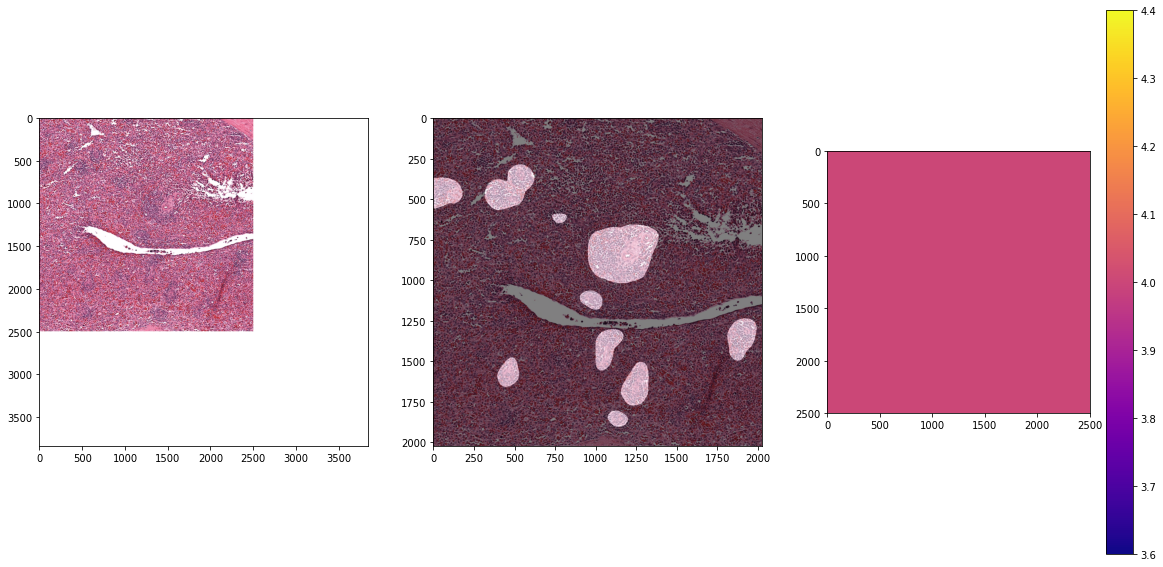

In [8]:
try:
    import matplotlib.pyplot as plt

    if img_unpadded.shape[:2] != orig_dim:
        shrink = orig_dim[0] < preds_full.shape[0]
        img_unpadded = cv2.resize(img_unpadded.astype(np.uint8), orig_dim, interpolation=DOWNSAMPLE_METHOD if shrink else UPSAMPLE_METHOD)

    fig, axes = plt.subplots(1,3, figsize=(20, 10))
    axes[0].imshow(img_full)
    axes[1].imshow(img_unpadded)
    axes[1].imshow(preds_full, alpha=0.5, cmap='gray')
    im = axes[2].imshow(preds_count.cpu().numpy(), cmap='plasma')
    fig.colorbar(im, ax=axes[2])
    plt.show()
    raise ValueError()
except Exception as e:
    pass

In [9]:
preds_count.max()

tensor(4, device='cuda:0', dtype=torch.int32)